### НИЯУ МИФИ. Лаботаторная работа #1. Ступников Иван, Б20-505

# Используемая система

```
Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         44 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  16
  On-line CPU(s) list:   0-15
Vendor ID:               AuthenticAMD
  Model name:            AMD Ryzen 7 4800H with Radeon Graphics
    CPU family:          23
    Model:               96
    Thread(s) per core:  2
    Core(s) per socket:  8
    Socket(s):           1
    Stepping:            1
    Frequency boost:     enabled
    CPU max MHz:         2900,0000
    CPU min MHz:         1400,0000
    BogoMIPS:            5789.02
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonst
                         op_tsc cpuid extd_apicid aperfmperf rapl pni pclmulqdq monitor ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand lahf_lm cmp_legacy svm extapic cr8_legacy abm s
                         se4a misalignsse 3dnowprefetch osvw ibs skinit wdt tce topoext perfctr_core perfctr_nb bpext perfctr_llc mwaitx cpb cat_l3 cdp_l3 hw_pstate ssbd mba ibrs ibpb stibp vmmcall fsgsb
                         ase bmi1 avx2 smep bmi2 cqm rdt_a rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 xsaves cqm_llc cqm_occup_llc cqm_mbm_total cqm_mbm_local clzero irperf xsaveerptr
                          rdpru wbnoinvd cppc arat npt lbrv svm_lock nrip_save tsc_scale vmcb_clean flushbyasid decodeassists pausefilter pfthreshold avic v_vmsave_vmload vgif v_spec_ctrl umip rdpid over
                         flow_recov succor smca sme sev sev_es
Virtualization features: 
  Virtualization:        AMD-V
Caches (sum of all):     
  L1d:                   256 KiB (8 instances)
  L1i:                   256 KiB (8 instances)
  L2:                    4 MiB (8 instances)
  L3:                    8 MiB (2 instances)
NUMA:                    
  NUMA node(s):          1
  NUMA node0 CPU(s):     0-15
Vulnerabilities:         
  Itlb multihit:         Not affected
  L1tf:                  Not affected
  Mds:                   Not affected
  Meltdown:              Not affected
  Mmio stale data:       Not affected
  Retbleed:              Mitigation; untrained return thunk; SMT enabled with STIBP protection
  Spec store bypass:     Mitigation; Speculative Store Bypass disabled via prctl and seccomp
  Spectre v1:            Mitigation; usercopy/swapgs barriers and __user pointer sanitization
  Spectre v2:            Mitigation; Retpolines, IBPB conditional, IBRS_FW, STIBP always-on, RSB filling
  Srbds:                 Not affected
  Tsx async abort:       Not affected


```

# Код
```
#include <cstdio>
#include <cstdlib>
#include <omp.h>

#define STEP 10000

int main(int argc, char** argv)
{
    const int count = 10000000;     ///< Number of array elements
    const int random_seed = 31337; ///< RNG seed
    // const int target = 16;          ///< Number to look for

    int* array = 0;                 ///< The array we need to find the max in
    int  index = -1;                ///< The index of the element we need

    /* Initialize the RNG */
    srand(random_seed);
    double start, end;

    /* Generate the random array */
    array = (int*)malloc(count*sizeof(int));
    for(int i=0; i<count; i++) { array[i] = rand(); }

    char filename[50];
    sprintf(filename, "trace.txt");
    FILE *fp = fopen(filename, "w");
    if (fp == NULL) {
        printf("Can't open file\n");
        exit(1);
    }
    int threads = omp_get_max_threads();
    // printf("THREADS - %d", threads);
    // exit(1);

    for (int thread = 1; thread <= threads; thread++) {

        for (int ind = 0; ind < count; ind += STEP) {
            int target = array[ind];
            int ans = -1;
            int tmp = count;
            start = omp_get_wtime();
#pragma omp parallel num_threads(thread) shared(array, tmp, target) reduction(max: ans) default(none)
            {
#pragma omp for
                for(int i=0; i<tmp; i++)
                {
                    if(array[i] == target) {
                        ans = i;
                        tmp = 0;
                    };
                }
            }
            end = omp_get_wtime();
            if (ind != count - STEP) {
                fprintf(fp, "%f;", end-start);
            } else {
                fprintf(fp, "%f\n", end-start);
            }
            printf("Found occurence of %d at index %d;\n", target, ans);
        }
    }
    fclose(fp);
    printf("Exit...\n");
    return(0);
}
```

In [10]:
# import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(15,10)})
dataset = []
with open("trace.txt", "r") as f:
    for _ in range(16):
        line = list(map(float, f.readline().split(";")))
        dataset.append(line)
        
for i in range(len(dataset)):
    line = dataset[i]
    line.sort()
    line = line[10:-10]
    dataset[i] = line

In [11]:
data = []
for i, line in enumerate(dataset):
    data.append([i+1, (sum(line)/len(line))*1000, "Real"])
saved = data.copy()
data1 = data
data_df = pd.DataFrame(data, columns=["Threads", "AvgTime", "Type"])
for i in range(1, len(data1)): 
    data1[i] = [data1[i][0], data1[0][1] / data1[i][0], "Perfect"]
data1[0][2] = "Perfect"
# pdf = pd.DataFrame(data1, columns=["Threads", "AvgTime"])
data1 = pd.DataFrame(data1, columns=["Threads", "AvgTime", "Type"])
all_data = pd.concat([data1, data_df])

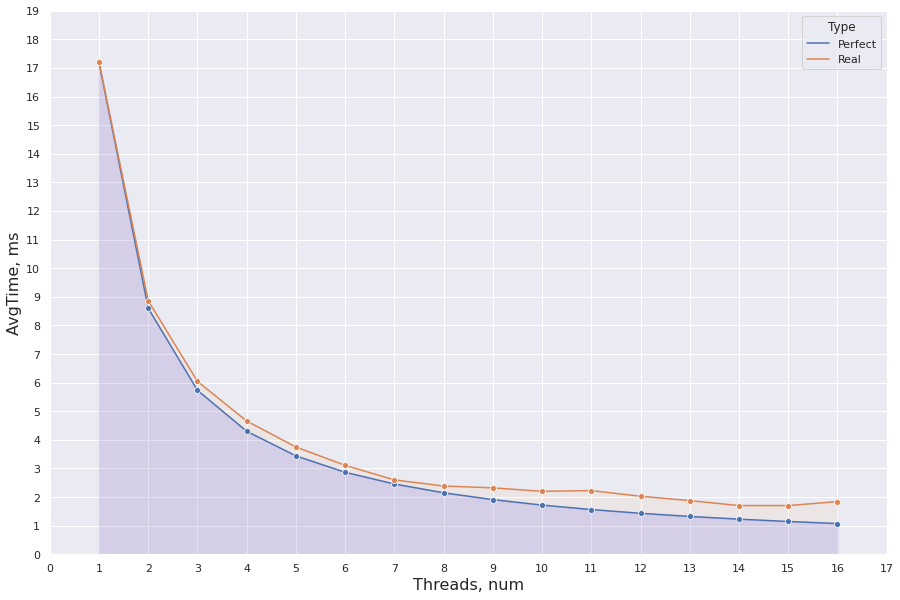

In [12]:
p = sns.lineplot(x="Threads", y="AvgTime", hue="Type", marker="o", data=all_data)
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("AvgTime, ms", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

p.fill_between(x1, y1, color="blue", alpha=0.1)
l2 = p.lines[1]

x2 = l2.get_xydata()[:, 0]
y2 = l2.get_xydata()[:, 1]

p.fill_between(x2, y2, color="orange", alpha=0.05)
p.margins(x=0, y=0)
_ = p.set_xticks(range(0, 18))
mas=[str(i) for i in range(0,18)]
mas1=[str(i) for i in range(0,20)]
_ = p.set_xticklabels(mas)
_ = p.set_yticks(range(0, 20))
_ = p.set_yticklabels(mas1)

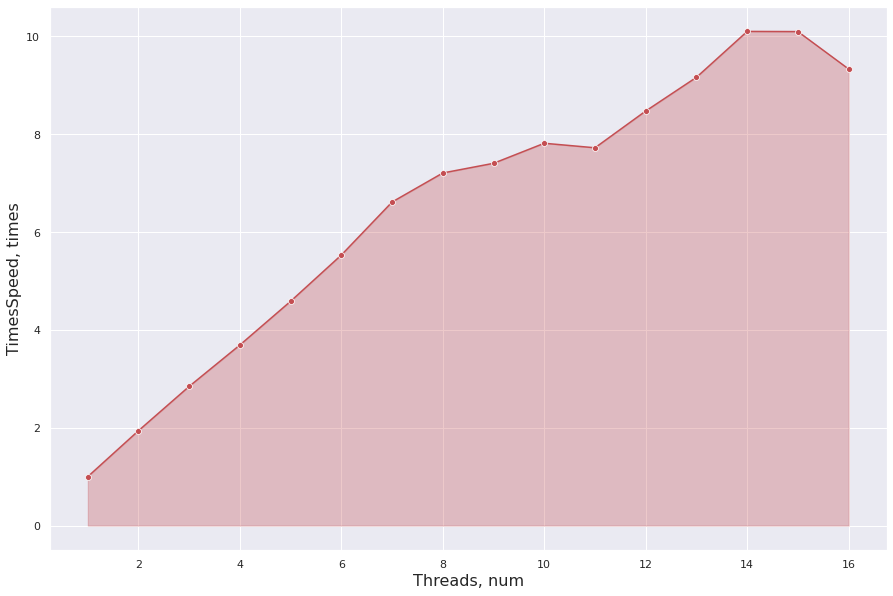

In [13]:
accceleration = [0] * 16
for i in range(0, len(accceleration)):
    accceleration[i] = [saved[i][0], saved[0][1]/saved[i][1]]
a_df = pd.DataFrame(accceleration, columns=["Threads", "TimesSpeed"])
p = sns.lineplot(x="Threads", y="TimesSpeed", marker="o", data=a_df, color='r')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("TimesSpeed, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="r", alpha=0.3)

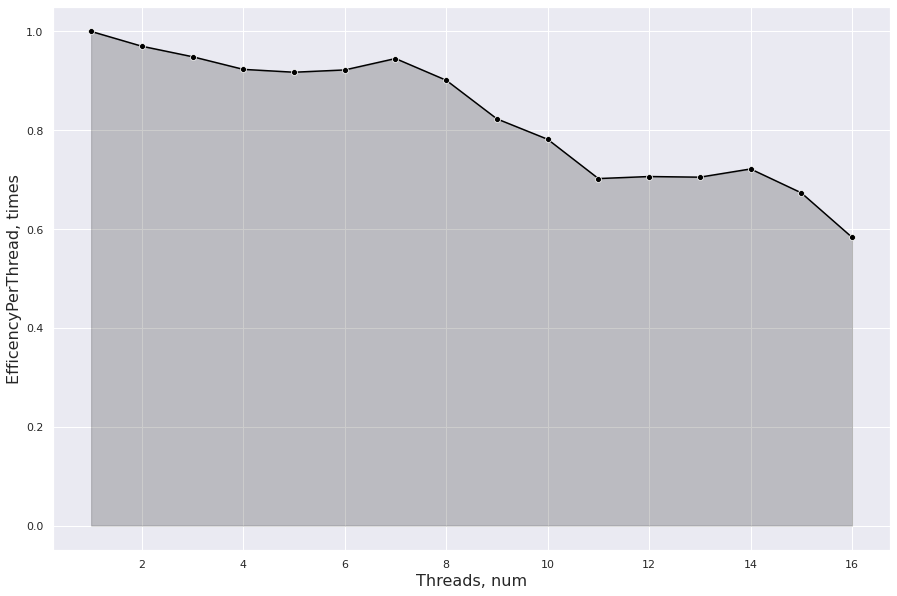

In [14]:
per_thread = [0] * 16
for i in range(0, len(per_thread)):
    per_thread[i] = [accceleration[i][0], accceleration[i][1]/accceleration[i][0]]
thr_df = pd.DataFrame(per_thread, columns=["Threads", "EfficencyPerThread"])
p = sns.lineplot(x="Threads", y="EfficencyPerThread", marker="o", data=thr_df, color='black')
p.set_xlabel("Threads, num", fontsize = 16)
p.set_ylabel("EfficencyPerThread, times", fontsize = 16)
l1 = p.lines[0]

x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]

_ = p.fill_between(x1, y1, color="black", alpha=0.2)

### Вывод
```
Мы оценили эфективность использования многопоточности. 
Так как процессор обладает 8 процессами по два потока, при использовании больше 8 потоков эффективность резко падает
```